In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# Sound for when code starts and ends
import os
duration = 1  # seconds
freq = 600  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

0

In [3]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

## Own code 
import import_ipynb
import metadata_options
import models_nn

importing Jupyter notebook from metadata_options.ipynb
importing Jupyter notebook from models_nn.ipynb


In [4]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

In [5]:
df.head()

,Unnamed: 0,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,...,rcmod,rel,root,tmod,xcomp,xsubj,Answer.1gamemove.yes_pc_agree,Answer.2reasoning.yes_pc_agree,Answer.4shareinformation.yes_pc_agree,Answer.3rapport.yes_pc_agree
0,5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.8,1.0,0.8
1,6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.6,0.8,0.8
2,7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,...,0.0,0.0,1.0,0.0,1.0,0.0,0.8,0.6,0.6,0.6
3,8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,...,0.0,0.0,1.0,0.0,0.0,0.0,0.8,0.8,0.8,0.8
4,9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,...,0.0,0.0,1.0,0.0,2.0,1.0,0.8,0.8,1.0,1.0


In [6]:
###################################
# pipeline-onehot Function blocks #
###################################

def sss_train_test_split(dataframe, class_name, n_splits, test_size, random_state):
    y = dataframe[class_name].copy()
    X = dataframe.drop([class_name], axis=1)
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    splits_generator = sss.split(X, y)

    for train_idx, test_idx in splits_generator:
        indices_train = train_idx
        indices_test = test_idx

    train = df.take(indices_train)
    test = df.take(indices_test)
    
    return indices_train, indices_test, train, test

def generate_class_weights(train_data, class_name, annotation_name):
    # Check if first class label is numeric or alphabetic
    if class_name == annotation_name:
        ## Convert to int type
        tmp_y_train = train_data[annotation_name].copy()
        tmp_y_train[annotation_name] = train_data[annotation_name].apply(lambda x : 1 if x == "Straightforward" else 0)
        y_train = tmp_y_train[annotation_name].to_numpy()
    else:
        y_train = train_data[annotation_name].to_numpy()
    
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    class_weight_dict = dict(enumerate(class_weights))
    
    return y_train, class_weight_dict

def label_preprocessing(y_data, label_encoder):
    out = label_encoder.fit_transform(y_data).reshape(-1,1)
    return out

def individual_model(annot_name, x_train_data, y_train_data, x_val_data, y_val_data, class_weight_dict, indiv_batch_size, indiv_epochs):
    model = models_nn.create_nn_model()
    model.compile(loss = 'binary_crossentropy',
                  optimizer = RMSprop(),
                  metrics = ['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
    history = model.fit(x_train_data,y_train_data,
                        batch_size=indiv_batch_size,
                        epochs=indiv_epochs,
                        validation_data=(x_val_data, y_val_data), 
#                         callbacks=[models_nn.early_stop],
                        class_weight=class_weight_dict,
                        verbose=0)
    
    pred = model.predict(x_train_data)
    pred_test = model.predict(x_val_data)

    pred_test_round = pred_test.round()
    
    validation_metrics_dict = history.history
    val_f1_list = history.history['val_f1_m']
    best_val_f1 = max(val_f1_list)
    best_val_prec = history.history['val_precision_m'][val_f1_list.index(best_val_f1)]
    best_val_recall = history.history['val_recall_m'][val_f1_list.index(best_val_f1)]
    macro_scores = precision_recall_fscore_support(y_val_data, pred_test_round, average='macro')
    print("#############################################################")
    print("Metrics for {} individual model:".format(annot_name))
    print("Best validation metrics: F1 = {}, Precision = {}, Recall = {}".format(best_val_f1,
                                                                                 best_val_prec,
                                                                                 best_val_recall))
    print("Macro validation metrics: F1 = {}, Precision = {}, Recall = {}".format(macro_scores[2],
                                                                                  macro_scores[0],
                                                                                  macro_scores[1]))
    return pred, pred_test

# (HARD-CODED)
def generate_encodings(gamemove_pred, reasoning_pred, shareinfo_pred, rapport_pred):
    pred_df_arr_full = []
    pred_df_arr = []
    for i in range(0, len(gamemove_pred)):
        pred_obj_1 = {}
        pred_obj_1['gamemove'] = gamemove_pred[i][0]
        pred_obj_1['reasoning'] = reasoning_pred[i][0]
        pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
        pred_df_arr.append(pred_obj_1)

        pred_obj_2 = pred_obj_1.copy()
        pred_obj_2['rapport'] = rapport_pred[i][0]
        pred_df_arr_full.append(pred_obj_2)

    pred_df_full = pd.DataFrame(pred_df_arr_full)
    pred_df = pd.DataFrame(pred_df_arr)
    return pred_df_full, pred_df

def joint_model(is_max, weights_name, pred_df_full, y_train_1, pred_df_full_test, y_test_1,
                pred_df, y_train_2, pred_df_test, y_test_2,
                class_weight_dict_1, class_weight_dict_2, joint_batch_size, joint_epochs):
    def helper(predict_name, pred_df, y_train, pred_df_test, y_test, class_weight_dict_1, joint_batch_size, joint_epochs):
        joint_full_model_1 = models_nn.create_joint_model(pred_df_full)
        history_1 = joint_full_model_1.fit(x=pred_df_full, 
                                           y=y_train_1, 
                                           epochs=joint_epochs, 
                                           batch_size=joint_batch_size, 
                                           validation_data=(pred_df_full_test,y_test_1), 
                                           #callbacks=[models_nn.callback], 
                                           class_weight=class_weight_dict_1,
                                           verbose=0)
        joint_predict_1 = joint_full_model_1.predict(pred_df_full_test)
        # joint_predict_round = []
        # for a in joint_predict:
        #     joint_predict_round.append(np.argmax(a))
        joint_predict_round_1 = joint_predict_1.round()
        out1 = precision_recall_fscore_support(y_test_1, np.array(joint_predict_round_1), average='macro')

        val_f1_list = history_1.history['val_f1_m']
        
        # if is_max, then take max f1 from history, otherwise take last value
        if is_max == True:
            best_val_f1 = max(val_f1_list)
        else:
            best_val_f1 = val_f1_list[-1]
        
        best_val_prec = history_1.history['val_precision_m'][val_f1_list.index(best_val_f1)]
        best_val_recall = history_1.history['val_recall_m'][val_f1_list.index(best_val_f1)]
        macro_scores = out1
        if weights_name == None:
            print("Metrics for {} joint model w/o weights:".format(predict_name))
        else:
            print("Metrics for {} joint model weighted by {}".format(predict_name, weights_name))
        print("Best validation metrics: F1 = {}, Precision = {}, Recall = {}".format(best_val_f1,
                                                                                     best_val_prec,
                                                                                     best_val_recall))
        print("Macro validation metrics: F1 = {}, Precision = {}, Recall = {}".format(macro_scores[2],
                                                                                      macro_scores[0],
                                                                                      macro_scores[1]))
        return [best_val_f1, best_val_prec, best_val_recall], macro_scores
    
    print("#############################################################")
    decep_1, decep_2 = helper("Deception", pred_df_full, y_train_1, pred_df_full_test, y_test_1, class_weight_dict_1, joint_batch_size, joint_epochs)
    rapport_1, rapport_2 = helper("Rapport", pred_df, y_train_2, pred_df_test, y_test_2, class_weight_dict_2, joint_batch_size, joint_epochs)

    
    return decep_1, decep_2, rapport_1, rapport_2

In [7]:
##################################################
# Main function for dataset sampling experiments #
##################################################

# Currently only supports annotations with 2 classes, i.e. binary

def dataset_sampling(dataframe, class_name, sampling_size_list, metadata_options_list, model_name, is_drop_rapport):
    
    # Misc variables
    results = {}
    
    # Model settings (for individual annotation models)
    models_nn.MODEL_NAME = model_name
    
    # Full dataframe proportions
    full_size = dataframe.shape[0]
    full_counts = dataframe[class_name].value_counts()
    print("Full dataset proportions w.r.t. {}".format(class_name))
    print(full_counts)
    full_counts_dict = full_counts.to_dict()
    full_counts_list = list(full_counts_dict.values())
    
    ## class_proportions is a list of class proportions, first item corresponding to first class, etc
    class_proportions = []
    for each_class_counts in full_counts_list:
        class_proportions.append(each_class_counts / full_size)

    # Looping through sample_size_list
    for each_sample_size in sampling_size_list:
        
        print("#################################")
        print("Sample size: {}".format(each_sample_size))
        print("#################################")
        
        ## Counting number of datapoints per class proportionate to main dataset
        class_sizes = [round(each_sample_size * class_proportions[0])]
        class_sizes.append(each_sample_size - class_sizes[0])

        ## Creating sub dataframe
        s0 = dataframe.loc[dataframe[class_name] == list(full_counts_dict.keys())[0]].sample(class_sizes[0]).index
        s1 = dataframe.loc[dataframe[class_name] == list(full_counts_dict.keys())[1]].sample(class_sizes[1]).index
        sub_df = dataframe.loc[s0.union(s1)]

        # Metadata settings
        print("#############################################################")
        print("Metadata options for current sample")
        df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(sub_df, *metadata_options_list)
  
        ## Train_test_split using SSS
        indices_train, indices_test, train, test = sss_train_test_split(sub_df, class_name, n_splits, test_size, random_state)
        
        ## Generate class weights dict and y_train data (HARD-CODED)
        y_train_deception, deception_class_weight_dict = generate_class_weights(train, class_name, "Input.deception_quadrant")
        y_train_rapport, rapport_class_weight_dict = generate_class_weights(train, class_name, 'Answer.3rapport.yes_label')
        y_train_share_information, share_info_class_weight_dict = generate_class_weights(train, class_name, 'Answer.4shareinformation.yes_label')
        y_train_reasoning, reasoning_class_weight_dict = generate_class_weights(train, class_name, 'Answer.2reasoning.yes_label')
        y_train_gamemove, gamemove_class_weight_dict = generate_class_weights(train, class_name, 'Answer.1gamemove.yes_label')
        print("#############################################################")
        print("Class weights generated")
        print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                          rapport_class_weight_dict,
                                                                                                          share_info_class_weight_dict,
                                                                                                          reasoning_class_weight_dict,
                                                                                                          gamemove_class_weight_dict))
        
        ## Train and test data preparation (HARD-CODED)
        X_train_col = train['Input.full_text']
        
        new_deception_test = test["Input.deception_quadrant"].copy()
        new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
        y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
        y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
        y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
        y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
        y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()
        X_test_col = test['Input.full_text']
        
        le = LabelEncoder()

        y_train_deception = label_preprocessing(y_train_deception, le)
        y_train_rapport = label_preprocessing(y_train_rapport, le)
        y_train_share_information = label_preprocessing(y_train_share_information, le)
        y_train_reasoning = label_preprocessing(y_train_reasoning, le)
        y_train_gamemove = label_preprocessing(y_train_gamemove, le)
        
        y_test_deception = label_preprocessing(y_test_deception, le)
        y_test_rapport = label_preprocessing(y_test_rapport, le)
        y_test_share_information = label_preprocessing(y_test_share_information, le)
        y_test_reasoning = label_preprocessing(y_test_reasoning, le)
        y_test_gamemove = label_preprocessing(y_test_gamemove, le)
        
        ## Tokenizer settings
        max_words = 1000
        max_len = 220

        tok = Tokenizer(num_words=max_words)

        tok.fit_on_texts(X_train_col)
        X_train_sequences = tok.texts_to_sequences(X_train_col)
        X_train = pad_sequences(X_train_sequences, maxlen=max_len)

        X_test_sequences = tok.texts_to_sequences(X_test_col)
        X_test = pad_sequences(X_test_sequences, maxlen=max_len)
        
        ## Individual Models (HARD-CODED)
        ### Deception pred and pred_test not needed
        _, _ = individual_model('Deception', X_train, y_train_deception, X_test, y_test_deception, deception_class_weight_dict, indiv_batch_size, indiv_epochs)
        rapport_pred, rapport_pred_test = individual_model('Rapport', X_train, y_train_rapport, X_test, y_test_rapport, rapport_class_weight_dict, indiv_batch_size, indiv_epochs)
        shareinfo_pred, shareinfo_pred_test = individual_model('Share Info', X_train, y_train_share_information, X_test, y_test_share_information, share_info_class_weight_dict, indiv_batch_size, indiv_epochs)
        reasoning_pred, reasoning_pred_test = individual_model('Reasoning', X_train, y_train_reasoning, X_test, y_test_reasoning, reasoning_class_weight_dict, indiv_batch_size, indiv_epochs)
        gamemove_pred, gamemove_pred_test = individual_model('Gamemove', X_train, y_train_gamemove, X_test, y_test_gamemove, gamemove_class_weight_dict, indiv_batch_size, indiv_epochs)
        
        ## Generate one-hot encodings (HARD-CODED)
        pred_df_full, pred_df = generate_encodings(gamemove_pred, reasoning_pred, shareinfo_pred, rapport_pred)
        pred_test_df_full, pred_test_df = generate_encodings(gamemove_pred_test, reasoning_pred_test, shareinfo_pred_test, rapport_pred_test)
        
        if is_drop_rapport:
            pred_df_full, pred_test_df_full = pred_df.copy(), pred_test_df.copy()
            
        ## Generate weighted one-hot encodings (HARD-CODED)
        pred_df_full_throughput, pred_df_throughput, pred_df_full_worktime, pred_df_worktime, pred_df_full_agreement, pred_df_agreement, pred_df_full_textlength, pred_df_textlength, pred_df_full_special, pred_df_special = metadata_options.construct_weighted_dataframe(indices_train, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_df, pred_df_full)
        pred_df_full_throughput_test, pred_df_throughput_test, pred_df_full_worktime_test, pred_df_worktime_test, pred_df_full_agreement_test, pred_df_agreement_test, pred_df_full_textlength_test, pred_df_textlength_test, pred_df_full_special_test, pred_df_special_test = metadata_options.construct_weighted_dataframe(indices_test, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_test_df, pred_test_df_full)
        print("#############################################################")
        print("Weighted one-hot encodings generated")
        
        ## Joint model w/o weights
        out1_wo_weights, _, out2_wo_weights, _ = joint_model(False, None, pred_df_full, y_train_deception, pred_test_df_full, y_test_deception,
                                                             pred_df, y_train_rapport, pred_test_df, y_test_rapport,
                                                             deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Throughput
        out1_tp, _, out2_tp, _ = joint_model(False, 'Throughput', pred_df_full_throughput, y_train_deception, pred_df_full_throughput_test, y_test_deception,
                                       pred_df_throughput, y_train_rapport, pred_df_throughput_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Worktime
        out1_wt, _, out2_wt, _ = joint_model(False, 'Worktime', pred_df_full_worktime, y_train_deception, pred_df_full_worktime_test, y_test_deception,
                                       pred_df_worktime, y_train_rapport, pred_df_worktime_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by PC Agreement
        out1_pc, _, out2_pc, _ = joint_model(False, 'PC Agreement', pred_df_full_agreement, y_train_deception, pred_df_full_agreement_test, y_test_deception,
                                       pred_df_agreement, y_train_rapport, pred_df_agreement_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Text Length
        out1_tl, _, out2_tl, _ = joint_model(False, 'Text Length', pred_df_full_textlength, y_train_deception, pred_df_full_textlength_test, y_test_deception,
                                       pred_df_textlength, y_train_rapport, pred_df_textlength_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        ## Joint model weighted by Special options
        out1_sp, _, out2_sp, _ = joint_model(False, 'Special', pred_df_full_special, y_train_deception, pred_df_full_special_test, y_test_deception,
                                       pred_df_special, y_train_rapport, pred_df_special_test, y_test_rapport,
                                       deception_class_weight_dict, rapport_class_weight_dict, joint_batch_size, joint_epochs)
        results['run_' + str(each_sample_size)] = [out1_wo_weights, out2_wo_weights, out1_tp, out2_tp, out1_wt, out2_wt, 
                                                   out1_pc, out2_pc, out1_tl, out2_tl, out1_sp, out2_sp]
    print("Done")
    return results

In [8]:
####################################
# Arguments for current experiment #
####################################

# Metadata options
throughput_option = 'TP1'
worktime_option = 'WT2'
pc_agreement_option = 'PC3'
textlength_option = 'TL2'
special_option = 'SP3'
k_option_for_tp = 3
metadata_options_choices = [throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp]

# Train_test_split SSS options
n_splits = 1
test_size = 0.2
random_state = 0

# Individual model options
# options: lstm, cnn, lstm-attn, bilstm
model_name = 'lstm'
indiv_batch_size = 128
indiv_epochs = 50

# Joint model options
joint_batch_size = 64
joint_epochs = 32

In [9]:
sampling_sizes = [250, 500, 750, 
                  1000, 1250, 1500, 1750, 
                  2000, 2250, 2500, 2750,
                  3000, 3500, 
                  4000, 4500, 
                  5000, 5500, 
                  6000, 6500, 
                  7000, 7500, 
                  8000, 8500, 
                  9000, 9500, 
                  10000, 10500, 11000, 11366]
# sampling_sizes = [11366]

results_dict = dataset_sampling(dataframe=df, 
                                class_name="Input.deception_quadrant", 
                                sampling_size_list=sampling_sizes, 
                                metadata_options_list=metadata_options_choices, 
                                model_name=model_name,
                                is_drop_rapport=False)

Full dataset proportions w.r.t. Input.deception_quadrant
Straightforward    10808
Cassandra            558
Name: Input.deception_quadrant, dtype: int64
#################################
Sample size: 250
#################################
#############################################################
Metadata options for current sample
TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
#############################################################
Class weights generated
Deception: {0: 100.0, 1: 0.5025125628140703} 
Rapport: {0: 4.0, 1: 0.5714285714285714}

Metrics for Deception joint model weighted by Text Length
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Metrics for Rapport joint model weighted by Text Length
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
#############################################################
Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
#################################
Sample size: 500
#################################
#############################################################
Metadata options for current sample
TP1: weight

Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.20634920634920637, Precision = 0.5, Recall = 0.13
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
#############################################################
Metrics for Deception joint model weighted by Text Length
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Metrics for Rapport joint model weighted by Text Length
Best validation metrics: F1 = 0.0, Precision = 0.0, 

#############################################################
Metrics for Deception individual model:
Best validation metrics: F1 = 1.0, Precision = 1.0, Recall = 1.0
Macro validation metrics: F1 = 0.49874686716791977, Precision = 0.4975, Recall = 0.5
#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.9411191940307617, Precision = 0.8923337459564209, Recall = 0.9955751895904541
Macro validation metrics: F1 = 0.4943536153716501, Precision = 0.4961685823754789, Recall = 0.4951481103166496
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.8698155879974365, Precision = 0.832269012928009, Recall = 0.9112744927406311
Macro validation metrics: F1 = 0.4658259993870134, Precision = 0.4639244130559267, Recall = 0.4692982456140351
#############################################################
Metrics for Reasoning individual model:
Be

Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9916770458221436, Precision = 0.9835668206214905, Recall = 1.0
Macro validation metrics: F1 = 0.4959677419354839, Precision = 0.492, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.9449983239173889, Precision = 0.982109785079956, Recall = 0.9110863208770752
Macro validation metrics: F1 = 0.4725738396624472, Precision = 0.49122807017543857, Recall = 0.45528455284552843
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9916770458221436, Precision = 0.9835668206214905, Recall = 1.0
Macro validation metrics: F1 = 0.4959677419354839, Precision = 0.492, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.4124968647956848, Precision = 1.0, Recall = 

Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9906244277954102, Precision = 0.9815341234207153, Recall = 1.0
Macro validation metrics: F1 = 0.49579831932773105, Precision = 0.49166666666666664, Recall = 0.5
#################################
Sample size: 1750
#################################
#############################################################
Metadata options for current sample
TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
#############################################################
Class weights ge

#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.8912115097045898, Precision = 0.815833330154419, Recall = 0.983729362487793
Macro validation metrics: F1 = 0.4845307683584367, Precision = 0.48711565504921894, Recall = 0.48462166575939036
#############################################################
Metrics for Gamemove individual model:
Best validation metrics: F1 = 0.9375104904174805, Precision = 0.9076663255691528, Recall = 0.9701701998710632
Macro validation metrics: F1 = 0.5380120932128541, Precision = 0.5343915343915344, Recall = 0.5488398976137395
#############################################################
Weighted one-hot encodings generated
#############################################################
Metrics for Deception joint model w/o weights:
Best validation metrics: F1 = 0.07413798570632935, Precision = 0.8571428656578064, Recall = 0.03884134069085121
Macro validation metrics: F1 = 0.06

Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9879976511001587, Precision = 0.9765625, Recall = 1.0
Macro validation metrics: F1 = 0.49324324324324326, Precision = 0.4866666666666667, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.46538594365119934, Precision = 0.9930555820465088, Recall = 0.3076098561286926
Macro validation metrics: F1 = 0.2514055886626377, Precision = 0.5128389075796557, Recall = 0.5987442922374429
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.9879976511001587, Precision = 0.9765625, Recall = 1.0
Macro validation metrics: F1 = 0.49324324324324326, Precision = 0.4866666666666667, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Text Length
Best validation metrics: F1 = 0.5254704356193542, Precision =

#############################################################
Metrics for Deception individual model:
Best validation metrics: F1 = 0.9830724596977234, Precision = 0.9670230150222778, Recall = 1.0
Macro validation metrics: F1 = 0.48837209302325585, Precision = 0.487012987012987, Recall = 0.48973880597014924
#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.9408143758773804, Precision = 0.8888980150222778, Recall = 1.0
Macro validation metrics: F1 = 0.5055870371634692, Precision = 0.5144688644688644, Recall = 0.5253986625514404
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.9183956384658813, Precision = 0.8643392324447632, Recall = 0.980887234210968
Macro validation metrics: F1 = 0.5231268134493942, Precision = 0.5227901851702546, Recall = 0.5235398623140128
#############################################################


Metrics for Deception joint model weighted by Throughput
Best validation metrics: F1 = 0.3296796977519989, Precision = 0.9864253997802734, Recall = 0.1994943916797638
Macro validation metrics: F1 = 0.19165572692096666, Precision = 0.5033095548391522, Recall = 0.525291573843533
Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9897137880325317, Precision = 0.979687511920929, Recall = 1.0
Macro validation metrics: F1 = 0.4945240101095198, Precision = 0.4891666666666667, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.9745551347732544, Precision = 0.9791048765182495, Recall = 0.9702572822570801
Macro validation metrics: F1 = 0.48717948717948717, Precision = 0.4888507718696398, Recall = 0.4855195911413969
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9897137880325317, Precision = 0.979687511920929, Reca

Metrics for Rapport joint model weighted by Text Length
Best validation metrics: F1 = 0.9868705868721008, Precision = 0.9743371605873108, Recall = 1.0
Macro validation metrics: F1 = 0.4934876989869754, Precision = 0.48714285714285716, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.5327402949333191, Precision = 0.9703962802886963, Recall = 0.3684993088245392
Macro validation metrics: F1 = 0.28852400565846836, Precision = 0.49589385303671013, Recall = 0.4617953730856957
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9868705868721008, Precision = 0.9743371605873108, Recall = 1.0
Macro validation metrics: F1 = 0.4934876989869754, Precision = 0.48714285714285716, Recall = 0.5
#################################
Sample size: 4000
#################################
#############################################################
Metadata options for 

#############################################################
Metrics for Rapport individual model:
Best validation metrics: F1 = 0.9431021809577942, Precision = 0.8935546875, Recall = 1.0
Macro validation metrics: F1 = 0.5011907339250921, Precision = 0.5085089573591272, Recall = 0.513865853234206
#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.8644176721572876, Precision = 0.7937142252922058, Recall = 0.9645093083381653
Macro validation metrics: F1 = 0.496, Precision = 0.496, Recall = 0.496
#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.8646841049194336, Precision = 0.7945808172225952, Recall = 0.9638832807540894
Macro validation metrics: F1 = 0.516125563624112, Precision = 0.5208473185649287, Recall = 0.5294997185477062
#############################################################
Metrics for Gamemove individual 

Metrics for Rapport joint model weighted by Throughput
Best validation metrics: F1 = 0.9875468611717224, Precision = 0.9755859375, Recall = 1.0
Macro validation metrics: F1 = 0.49367088607594933, Precision = 0.4875, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.6575531363487244, Precision = 0.9737942814826965, Recall = 0.5008718371391296
Macro validation metrics: F1 = 0.3503118503118503, Precision = 0.49524952495249525, Recall = 0.4512820512820513
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9875468611717224, Precision = 0.9755859375, Recall = 1.0
Macro validation metrics: F1 = 0.49367088607594933, Precision = 0.4875, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.8397901058197021, Precision = 0.979733407497406, Rec

Metrics for Deception joint model weighted by Special
Best validation metrics: F1 = 0.7617970705032349, Precision = 0.9687052965164185, Recall = 0.6337119340896606
Macro validation metrics: F1 = 0.40219772313519225, Precision = 0.49620028321309134, Recall = 0.46851591760299627
Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9857892990112305, Precision = 0.9722222089767456, Recall = 1.0
Macro validation metrics: F1 = 0.492619926199262, Precision = 0.48545454545454547, Recall = 0.5
#################################
Sample size: 6000
#################################
#############################################################
Metadata options for current sample
TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)
TL2:

#############################################################
Metrics for Share Info individual model:
Best validation metrics: F1 = 0.8089728951454163, Precision = 0.8328931927680969, Recall = 0.7904825806617737
Macro validation metrics: F1 = 0.5102077723747137, Precision = 0.5189643832340103, Recall = 0.528767206119267
#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.8457462191581726, Precision = 0.846343994140625, Recall = 0.8465045690536499
Macro validation metrics: F1 = 0.49430959366942295, Precision = 0.5091808822262428, Recall = 0.5143518518518518
#############################################################
Metrics for Gamemove individual model:
Best validation metrics: F1 = 0.9569263458251953, Precision = 0.917755663394928, Recall = 1.0
Macro validation metrics: F1 = 0.44021396623898634, Precision = 0.5088056709994989, Recall = 0.5285714285714286
###############################################

Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.039688970893621445, Precision = 0.7272727489471436, Recall = 0.020504700019955635
Macro validation metrics: F1 = 0.05270054845801041, Precision = 0.5167638483965015, Recall = 0.5103397341211225
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9830869436264038, Precision = 0.9670251607894897, Recall = 1.0
Macro validation metrics: F1 = 0.49164851125635445, Precision = 0.4835714285714286, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.9719128012657166, Precision = 0.9674264788627625, Recall = 0.9766811728477478
Macro validation metrics: F1 = 0.5115347577910206, Precision = 0.5142093946044202, Recall = 0.5102915676578255
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.9830869436264038, Precision = 0.96702516078

Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9818970561027527, Precision = 0.964657723903656, Recall = 1.0
Macro validation metrics: F1 = 0.491007804546997, Precision = 0.48233333333333334, Recall = 0.5
#################################
Sample size: 8000
#################################
#############################################################
Metadata options for current sample
TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
#############################################################
Class weights gener

#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.802680492401123, Precision = 0.8579712510108948, Recall = 0.7570892572402954
Macro validation metrics: F1 = 0.497986917291272, Precision = 0.516914117377662, Recall = 0.5288364142820967
#############################################################
Metrics for Gamemove individual model:
Best validation metrics: F1 = 0.9685978293418884, Precision = 0.9394221305847168, Recall = 1.0
Macro validation metrics: F1 = 0.4925560094406086, Precision = 0.5099791432696936, Recall = 0.5276094315948959
#############################################################
Weighted one-hot encodings generated
#############################################################
Metrics for Deception joint model w/o weights:
Best validation metrics: F1 = 0.9069972634315491, Precision = 0.953109622001648, Recall = 0.8663062453269958
Macro validation metrics: F1 = 0.47105543273560957, Prec

Metrics for Deception joint model weighted by Worktime
Best validation metrics: F1 = 0.21303115785121918, Precision = 0.9254366755485535, Recall = 0.12291999161243439
Macro validation metrics: F1 = 0.14818521884496308, Precision = 0.49705067848241485, Recall = 0.4910833144952654
Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9808968305587769, Precision = 0.9628232717514038, Recall = 1.0
Macro validation metrics: F1 = 0.49022939677145283, Precision = 0.48083333333333333, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.7888838648796082, Precision = 0.9578903913497925, Recall = 0.6722806096076965
Macro validation metrics: F1 = 0.4217470664928292, Precision = 0.4933009902024599, Recall = 0.4602767940120061
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.9808968305587769, Precision = 0.96282327175

Metrics for Rapport joint model weighted by Special
Best validation metrics: F1 = 0.9764846563339233, Precision = 0.9542613625526428, Recall = 1.0
Macro validation metrics: F1 = 0.4884221863220248, Precision = 0.47736842105263155, Recall = 0.5
#################################
Sample size: 10000
#################################
#############################################################
Metadata options for current sample
TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
#############################################################
Class weights ge

#############################################################
Metrics for Reasoning individual model:
Best validation metrics: F1 = 0.8749421238899231, Precision = 0.8440841436386108, Recall = 0.9096167087554932
Macro validation metrics: F1 = 0.48493925992322606, Precision = 0.511393045615557, Recall = 0.5193867107542119
#############################################################
Metrics for Gamemove individual model:
Best validation metrics: F1 = 0.934536874294281, Precision = 0.9270634651184082, Recall = 0.9425086975097656
Macro validation metrics: F1 = 0.45911056804122286, Precision = 0.4977483602490401, Recall = 0.4933502922462145
#############################################################
Weighted one-hot encodings generated
#############################################################
Metrics for Deception joint model w/o weights:
Best validation metrics: F1 = 0.6463261246681213, Precision = 0.952073872089386, Recall = 0.49190348386764526
Macro validation metrics: F1 = 0.3619

Metrics for Rapport joint model weighted by Worktime
Best validation metrics: F1 = 0.9718860983848572, Precision = 0.9458333849906921, Recall = 1.0
Macro validation metrics: F1 = 0.4862213918729566, Precision = 0.4731818181818182, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by PC Agreement
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.05090595340811044, Precision = 0.026818181818181817, Recall = 0.5
Metrics for Rapport joint model weighted by PC Agreement
Best validation metrics: F1 = 0.9718860983848572, Precision = 0.9458333849906921, Recall = 1.0
Macro validation metrics: F1 = 0.4862213918729566, Precision = 0.4731818181818182, Recall = 0.5
#############################################################
Metrics for Deception joint model weighted by Text Length
Best validation metrics: F1 = 0.0, Precision = 0.0, Recall = 0.0
Macro validation metrics: F1 = 0.05090

In [10]:
def translate_into_pandas(results_dictionary, metric_of_focus):
    def helper(metric_of_focus_number):
        new_dict = {}
        for each_key, each_values_list in results_dictionary.items():
            new_dict[each_key[4:]] = []
            for each in each_values_list:
                new_dict[each_key[4:]].append(each[metric_of_focus_number])
        out_df = pd.DataFrame.from_dict(new_dict)
        return out_df
    
    if metric_of_focus == 'F1':
        metric_of_focus_number = 0
    elif metric_of_focus == 'Precision':
        metric_of_focus_number = 1
    elif metric_of_focus == 'Recall':
        metric_of_focus_number = 2
        
    return helper(metric_of_focus_number)

metric_of_focus = ['Precision', 'Recall', 'F1']

for metric in metric_of_focus:
    experiment_df = translate_into_pandas(results_dict, metric)
    results_name = "./output/dataset_sampling_" + str(len(sampling_sizes)) + '_' + str(metric) + "_pts_" + model_name
    experiment_df.to_csv(results_name + ".csv", index=False)

In [11]:
experiment_df.head()

,250,500,750,1000,1250,1500,1750,2000,2250,2500,...,7000,7500,8000,8500,9000,9500,10000,10500,11000,11366
0,0.0,0.0,0.245979,0.373764,0.000000,0.985850,0.890901,0.074138,0.364054,0.766645,...,0.973390,0.929888,0.803843,0.906997,0.085796,0.635665,0.589798,0.646326,0.775037,0.665252
1,0.0,0.0,0.994751,0.998031,0.991677,0.990624,0.987926,0.989823,0.987998,0.984849,...,0.983087,0.981897,0.981339,0.977576,0.980897,0.976485,0.971323,0.977432,0.971886,0.974501
2,0.0,0.0,0.000000,0.611731,0.605159,0.931800,0.897630,0.785762,0.672278,0.984849,...,0.648748,0.494110,0.641119,0.906686,0.604520,0.757222,0.956771,0.000000,0.732571,0.974501
3,0.0,0.0,0.994751,0.998031,0.991677,0.990624,0.987926,0.989823,0.987998,0.984849,...,0.983087,0.981897,0.981339,0.977576,0.980897,0.976485,0.971323,0.977432,0.971886,0.974501
4,0.0,0.0,0.733365,0.998031,0.944998,0.958683,0.983883,0.935494,0.210525,0.982612,...,0.039689,0.980843,0.981339,0.276821,0.213031,0.034844,0.840471,0.977432,0.916284,0.974501


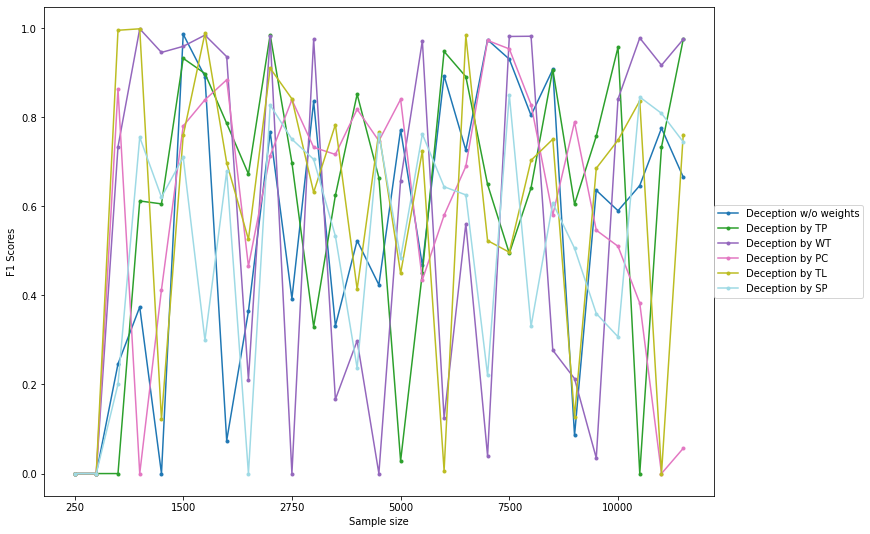

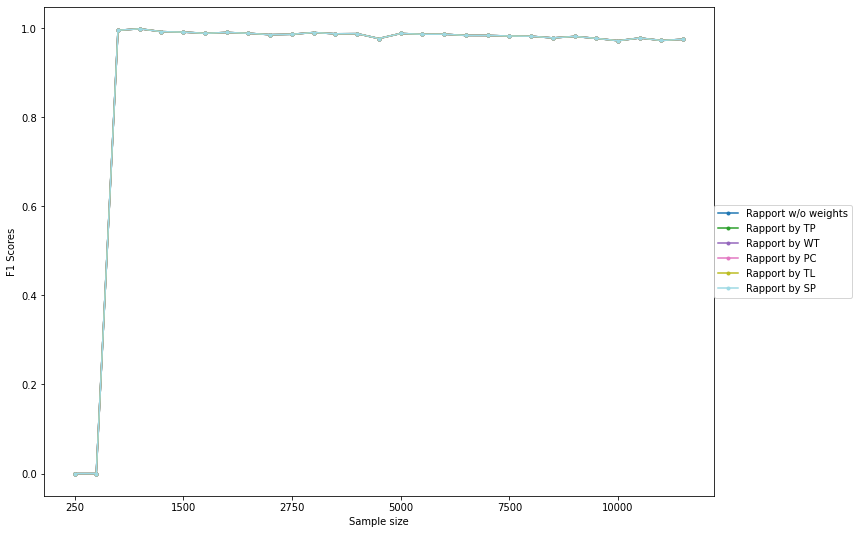

In [12]:
# experiment_df = pd.read_csv("/home/kaiyuan/Desktop/ky_code/affcon/diplomacy-betrayal/output/dataset_sampling_29_F1_pts_last_cnn.csv")

predict_option = ['deception', 'rapport']

for option in predict_option:
    if option == "rapport":
        # to drop these
        row_names = [0,2,4,6,8,10]
    else:
        # to drop these
        row_names = [1,3,5,7,9,11]

    experiment_df_option = experiment_df.drop(row_names)
    
    exp_plot_df = experiment_df_option.T.reset_index()
    rename_col_names = {0: 'Deception w/o weights',
                        1: 'Rapport w/o weights',
                        2: 'Deception by TP',
                        3: 'Rapport by TP',
                        4: 'Deception by WT',
                        5: 'Rapport by WT',
                        6: 'Deception by PC',
                        7: 'Rapport by PC',
                        8: 'Deception by TL',
                        9: 'Rapport by TL',
                        10: 'Deception by SP',
                        11: 'Rapport by SP'}
    exp_plot_df = exp_plot_df.rename(columns=rename_col_names)
    
    plot = exp_plot_df.plot('index',list(exp_plot_df.columns)[1:],style='.-', figsize=(12,9), colormap='tab20')
    plot.set_xlabel('Sample size', size=10)
    plot.set_ylabel('F1 Scores', size=10)
    lgd = plot.legend(loc='center left',bbox_to_anchor=(1.0, 0.5), borderaxespad=0.)
    plot = plot.get_figure()
    plot.savefig(results_name + "_" + option + '.jpg', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [13]:
duration = 10  # seconds
freq = 600  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

0